In [7]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(VennDiagram)
options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
functR <- 'priler_project/Figure_CASTom-iGEx_paper/Functions_prediction_plots.R'
source(functR)

color_file <- 'priler_project/Figures/color_tissues.txt'

fold <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/OUTPUT_all/'
pheno <- 'SCZ'
fold_rep <- 'SCZ_PGC/eQTL_PROJECT/replication_CMC/'
train_fold <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/'
type_dat <- 'SCZ-PGC'
pval_FDR <- 0.05

# load results
color_tissues <- read.table(color_file, h=T, stringsAsFactors = F)
tscore <- read.delim(sprintf('%stscore_pval_%s_covCorr.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathR <- read.delim(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathGO <- read.delim(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathWiki <- read.delim(sprintf('%scustomPath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathCMC <- read.delim(sprintf('%scustomPath_CMC_GeneSets_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')

tissues <- unique(tscore$tissue)
train_fold <- paste0(train_fold, tissues, '/')
out_fold <- 'priler_project/Figure_CASTom-iGEx_paper/SCZ_part1/'

# gene location
tscore$start_position <- NA
tscore$chrom <- NA
tscore$TSS_start <- NA

for(i in 1:length(train_fold)){
  
  tmp <- read.table(sprintf('%s/resPrior_regEval_allchr.txt', train_fold[i]), h=T,stringsAsFactors = F)
  tmp <- tmp[match(tscore$ensembl_gene_id[tscore$tissue == tissues[i]], tmp$ensembl_gene_id),]
  tscore$start_position[tscore$tissue == tissues[i]] <- tmp$start_position
  tscore$chrom[tscore$tissue == tissues[i]] <- tmp$chrom
  tscore$TSS_start[tscore$tissue == tissues[i]] <- tmp$TSS_start 
  
}

# load loci and gwas res
tscore_loci <- fread(sprintf('%sGeneTscores_SCZ_annotated.txt', fold), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
gwas_res <- fread('refData/Original_SCZ_variants_PGC.txt.gz',  h=T, stringsAsFactors = F, sep = '\t', data.table = F)
colnames(gwas_res)[colnames(gwas_res) == 'CHR'] <- 'chr'
colnames(gwas_res)[colnames(gwas_res) == 'P'] <- 'p.value_gc'
colnames(gwas_res)[colnames(gwas_res) == 'BP'] <- 'bp_hg19'
gwas_res$chr <- substr(gwas_res$chr, 4, 6)
gwas_res$Markername <- paste0(gwas_res$chr, ':', gwas_res$bp_hg19, '_', gwas_res$A1, '_', gwas_res$A2)
# correct pvalues
gwas_res <- gwas_res[!is.na(gwas_res$chr), ]
# correct pvalues
gwas_res$pval_corr <- p.adjust(gwas_res$p.value_gc, method = 'BH')
gwas_res$chrom <- paste0('chr', gwas_res$chr)

[1] "C"

In [8]:
#################################
### compare results with GWAS ###
#################################
ann_loci <- data.frame(loci_id = unique(tscore_loci$loci_complete), stringsAsFactors = F)
ann_loci$chr <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][1])
tmp <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][2])
ann_loci$start <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][1])
ann_loci$end <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][2])
ann_loci$best_GWAS_pval <- NA
ann_loci$best_GWAS_sign <- NA
ann_loci$best_GWAS_signBH <- NA

for(i in 1:nrow(ann_loci)){
   start_loci <- as.numeric(ann_loci$start[i])
   end_loci <- as.numeric(ann_loci$end[i])                
   id <- gwas_res$chrom == ann_loci$chr[i] & gwas_res$bp_hg19 <= end_loci & gwas_res$bp_hg19 >= start_loci
   tmp <- gwas_res[id, ]
   if(nrow(tmp)>0){
       ann_loci$best_GWAS_pval[i] <- min(tmp$p.value_gc)
       ann_loci$best_GWAS_sign[i] <- any(tmp$p.value_gc <= 5*10^-8)
       ann_loci$best_GWAS_signBH[i] <- any(tmp$pval_corr <= 0.05)     
   }
}


In [9]:
# how many loci intersect significant GWAS results (Genomewide and BH correction)
table(ann_loci$best_GWAS_sign, ann_loci$best_GWAS_signBH)

# annotate gene table:
tscore_loci$best_GWAS_signBH <- NA
tscore_loci$best_GWAS_sign <- NA
tscore_loci$best_GWAS_pval <- NA
for(i in 1:nrow(ann_loci)){
    tscore_loci$best_GWAS_signBH[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_signBH[i]
    tscore_loci$best_GWAS_sign[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_sign[i]
    tscore_loci$best_GWAS_pval[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_pval[i]
}

tscore_loci[!tscore_loci$best_GWAS_signBH,]
paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & !tscore_loci$best_GWAS_signBH,]))
paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWAS_signBH,]))

       
        FALSE TRUE
  FALSE    24  170
  TRUE      0   48

,type,chrom,TSS_start,start_position,end_position,ensembl_gene_id,external_gene_name,dev_geno,test_dev_geno,Dx_beta,⋯,Dx_Cochran_pval,Dx_model,tissue,Dx_pval_BHcorr_overall,loci_tissue_specific,loci,loci_complete,best_GWAS_signBH,best_GWAS_sign,best_GWAS_pval
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>
51,heritable,chr2,119981384,119981384,120023228,ENSG00000115107,STEAP3,0.14075588,0.045661734,0.02725274,⋯,0.94341145,fixed,DLPC_CMC,0.047821045,chr2:119.8-120.2Mb,chr2:119.8-120.2Mb,chr2:119781384-120181384,FALSE,FALSE,0.0009315
55,heritable,chr2,179695528,179390716,179695529,ENSG00000155657,TTN,0.32428856,0.225229259,-0.02726879,⋯,0.18499663,fixed,DLPC_CMC,0.041094990,chr2:179.5-179.9Mb,chr2:179.5-179.9Mb,chr2:179495528-179895528,FALSE,FALSE,0.0083500
74,not_heritable,chr3,139302434,139301770,139302435,ENSG00000214280,RP11-553K23.2,0.06509924,0.011339181,-0.02800573,⋯,0.99657970,fixed,DLPC_CMC,0.039812256,chr3:139.1-139.5Mb,chr3:139.1-139.5Mb,chr3:139102434-139502434,FALSE,FALSE,0.0020190
76,heritable,chr4,56815037,56815037,56899529,ENSG00000174799,CEP135,0.09144911,0.012033134,-0.02829313,⋯,0.14735244,fixed,DLPC_CMC,0.038640121,chr4:56.6-57Mb,chr4:56.6-57Mb,chr4:56615037-57015037,FALSE,FALSE,0.0011620
161,heritable,chr7,32801398,32620561,32801399,ENSG00000229358,DPY19L1P1,0.08044062,0.010073114,0.02943916,⋯,0.70989472,fixed,DLPC_CMC,0.028258826,chr7:32.6-33Mb,chr7:32.3-33Mb,chr7:32297369-33001398,FALSE,FALSE,0.0024670
198,heritable,chr10,99094457,99092255,99094458,ENSG00000181274,FRAT2,0.08956754,0.047147415,-0.02701543,⋯,0.01550537,fixed,DLPC_CMC,0.051299923,chr10:98.9-99.3Mb,chr10:98.9-99.3Mb,chr10:98894457-99294457,FALSE,FALSE,0.0012950
234,heritable,chr15,51200869,51200869,51298097,ENSG00000081014,AP4E1,0.18377315,0.146957471,0.02825919,⋯,0.43434767,fixed,DLPC_CMC,0.035833194,chr15:51-51.4Mb,chr15:51-51.4Mb,chr15:51000869-51400869,FALSE,FALSE,0.0007054
293,not_heritable,chr19,41856816,41856816,41889988,ENSG00000142046,TMEM91,0.03410093,0.015905612,0.03406722,⋯,0.24665514,fixed,DLPC_CMC,0.006304102,chr19:41.7-42.1Mb,chr19:41.6-42.1Mb,chr19:41616094-42103383,FALSE,FALSE,0.0025560
300,heritable,chr21,33959682,33948862,33959683,ENSG00000242220,TCP10L,0.11393063,0.051445436,0.03027785,⋯,0.05500322,fixed,DLPC_CMC,0.022628270,chr21:33.8-34.2Mb,chr21:33.8-34.2Mb,chr21:33759682-34159682,FALSE,FALSE,0.0038860


[1] "unique new genes: 30"

[1] "total new genes: 32"

In [10]:
# add replication
fold_rep <- 'SCZ_PGC/eQTL_PROJECT/replication_CMC/'
tscore_repl <- fread(sprintf('%stscore_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
rep_df <- data.frame(CMC_z = c(), CMC_pval = c(), stringsAsFactors = F)

for(i in 1:nrow(tscore_loci)){
    if(tscore_loci$tissue[i] == 'DLPC_CMC'){
        tmp <- tscore_repl[tscore_repl$ensembl_gene_id == tscore_loci$ensembl_gene_id[i] & tscore_repl$tissue == tscore_loci$tissue[i],]
        new <- data.frame(CMC_z = tmp$SCZCMC_rep_z, CMC_pval =tmp$SCZCMC_rep_pval,  stringsAsFactors = F)
    }else{
        new <- data.frame(CMC_z = NA, CMC_pval = NA,  stringsAsFactors = F)
    }
    rep_df <- rbind(rep_df,new)
}
tscore_complete <- cbind(tscore_loci, rep_df)
tscore_complete$replicated <- NA
tscore_complete$replicated <- sign(tscore_complete$Dx_z * tscore_complete$CMC_z)==1

# save
write.table(tscore_complete, file = sprintf('%sGeneTscores_SCZ_annotated_intGWAS_withReplicationCMC.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

In [11]:
############################################
### annotate pathway significant results ###
############################################

common_i <- intersect(colnames(pathR), colnames(pathGO))
common_i <- intersect(common_i, colnames(pathWiki))
common_i <- intersect(common_i, colnames(pathCMC))
tmp1 <- pathR[, common_i]
tmp2 <- pathGO[, common_i]
tmp3 <- pathWiki[, common_i]
tmp4 <- pathCMC[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tmp3$type_path <- 'WikiHuman'
tmp4$type_path <- 'CMCGeneSet'
tot_path <- rbind(tmp1, tmp2, tmp3, tmp4)
# consider only significant ones:
tot_path <- tot_path[, !colnames(tot_path) %in% 'Dx_pval_BHcorr_overall']
sign_path <- tot_path[tot_path[,15]<= 0.05,]

# add a column that indicates whether there is any gene from new loci
sign_path$gene_from_newloci <- NA

for(i in 1:nrow(sign_path)){
    
    id <- sapply(tscore_complete$external_gene_name, function(x) grepl(x, sign_path$genes_path[i])) & sign_path$tissue[i] == tscore_complete$tissue
    id <- id & !tscore_complete$best_GWAS_signBH
    if(any(id)){
        sign_path$gene_from_newloci[i] <- paste0(unique(tscore_complete$external_gene_name[id]), collapse = ',')
    }
}
paste('pathway from new loci:', sum(!is.na(sign_path$gene_from_newloci)), 'out of', nrow(sign_path))
sign_path[!is.na(sign_path$gene_from_newloci),]

# add replication
pathR_repl <- fread(sprintf('%spathR_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
pathGO_repl <- fread(sprintf('%spathGO_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
common_i <- intersect(colnames(pathR_repl), colnames(pathGO_repl))
tmp1 <- pathR_repl[, common_i]
tmp2 <- pathGO_repl[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tot_path_repl <- rbind(tmp1, tmp2)

rep_df <- data.frame(CMC_z = c(), CMC_pval = c(), stringsAsFactors = F)
for(i in 1:nrow(sign_path)){
    if(sign_path$tissue[i] == 'DLPC_CMC' & sign_path$type_path[i] %in% c('Reactome', 'GO')){
        tmp <- tot_path_repl[tot_path_repl$path == sign_path$path[i] & tot_path_repl$tissue == sign_path$tissue[i],]
        new <- data.frame(CMC_z = tmp$SCZCMC_rep_z, CMC_pval =tmp$SCZCMC_rep_pval, stringsAsFactors = F)
    }else{
        new <- data.frame(CMC_z = NA, CMC_pval = NA, stringsAsFactors = F)
    }
    rep_df <- rbind(rep_df,new)
}
path_complete <- cbind(sign_path, rep_df)
path_complete$replicated <- NA
path_complete$replicated <- sign(path_complete$Dx_z * path_complete$CMC_z)==1
# replicated pathways with genes from new loci
table(path_complete$replicated, !is.na(path_complete$gene_from_newloci))
# save
write.table(path_complete, file = sprintf('%sPathScores_SCZ_annNewLoci_withReplicationCMC.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)


[1] "pathway from new loci: 17 out of 1578"

path                                                                     
2387  Membrane binding and targetting of GAG proteins                          
7922  multivesicular body                                                      
7984  clathrin-coated pit                                                      
9330  enzyme binding                                                           
10689 regulation of protein kinase activity                                    
13556 nucleotide binding                                                       
13850 protein binding                                                          
14552 nucleoside-triphosphatase activity                                       
14577 viral protein processing                                                 
14732 negative regulation of BMP signaling pathway                             
15466 calcium ion transmembrane transport                                      
16272 defense response                                                         
17273 transcriptionally active chromatin                                       
17310 regulation of growth                                                     
21730 enzyme binding                                                           
28451 Nucleotide Metabolism WP404                                              
29273 HBA:Reticular_Nucleus_of_Thalamus_localMarker(top200)_IN_Ventral_Thalamus
      ngenes_tscore ngenes_path mean_dev_geno sd_dev_geno mean_test_dev_geno
2387    2             15        0.1140201     0.03992997  0.02489901        
7922    5             19        0.1577076     0.09563383  0.09017098        
7984   16             53        0.1413775     0.12049798  0.08603877        
9330   86            259        0.1407879     0.10192274  0.08101899        
10689   9             19        0.1553011     0.07971658  0.07550657        
13556  52            564        0.1807091     0.14750738  0.10036021        
13850 799           9305        0.1903060     0.16252953  0.09162340        
14552  15            143        0.2383471     0.13707363  0.13218043        
14577   2             12        0.1140201     0.03992997  0.02489901        
14732   3             35        0.2419276     0.34429778  0.11918578        
15466   6             53        0.2390719     0.14985713  0.07266223        
16272  11            107        0.2755137     0.13541648  0.12418542        
17273   2             11        0.1419488     0.10556373  0.04530145        
17310   3             54        0.1099316     0.06428465  0.01015209        
21730  13            259        0.0706922     0.08785964  0.02122251        
28451   2             19        0.1578572     0.13834791  0.11144517        
29273  69            200        0.1527335     0.10897996  0.08923240        
      sd_test_dev_geno mean_gene_corr sd_gene_corr Dx_beta     ⋯ Dx_qval     
2387  0.028179741       2.581702e-03          NA   -0.04352529 ⋯ 1.894927e-02
7922  0.098223877      -2.670464e-03  0.03351222   -0.08039933 ⋯ 3.670498e-03
7984  0.115094775       1.142664e-04  0.03393972    0.11733856 ⋯ 2.304980e-02
9330  0.089706135       2.594174e-04  0.03592551   -0.27916546 ⋯ 1.876957e-02
10689 0.071230838      -6.140652e-04  0.03279106   -0.15535321 ⋯ 4.208603e-06
13556 0.128964206       2.355966e-05  0.03389847    0.21867200 ⋯ 1.307449e-02
13850 0.122385180       7.494400e-05  0.03689975    0.99352361 ⋯ 2.246002e-03
14552 0.126456094      -2.698716e-04  0.03413809    0.12819125 ⋯ 6.203159e-03
14577 0.028179741       2.581702e-03          NA   -0.04352529 ⋯ 1.162756e-02
14732 0.186485698       4.739243e-03  0.02533271    0.05909681 ⋯ 4.710133e-03
15466 0.102205466      -1.675367e-04  0.03324356    0.07737963 ⋯ 9.247002e-03
16272 0.136040185       3.289870e-03  0.03768810   -0.11730176 ⋯ 2.299835e-03
17273 0.006606398       4.423402e-03          NA   -0.03844678 ⋯ 3.209519e-02
17310 0.006792579       5.471375e-03  0.03505505   -0.05493659 ⋯ 9.496187e-03
21730 0.03

       
        FALSE TRUE
  FALSE    90    2
  TRUE    167    2


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                                   980                                    316 
pathway P < genes P & genes FDR > 0.05 
                                   282 


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                             0.6210393                              0.2002535 
pathway P < genes P & genes FDR > 0.05 
                             0.1787072 

[1] 1578

,type_path,tissue,path,ngenes_tscore,log10p,zstat,impr,no_sign_genes,mean_gene_log10p,max_gene_log10p,min_gene_log10p,mean_gene_z,max_gene_z,min_gene_z,class,class_effect,tissue_tot
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<fct>
969,GO,Brain_Cortex,calcium-dependent cell-cell adhesion via plasma membrane cell adhesion molecules,2,4.835938,4.334786,1,FALSE,2.6641167,2.883428,2.444805349,3.0631385,3.214242,2.912035,pathway P < genes P & genes FDR < 0.05,NA,Combined tissues
694,GO,Brain_Cerebellar_Hemisphere,cell adhesion,44,4.566025,4.196035,0,FALSE,0.8187486,6.167351,0.011404262,0.6310234,4.966928,-3.184264,genes P < pathway P,NA,Combined tissues
955,GO,Brain_Cortex,cell adhesion,27,2.512825,2.960615,0,FALSE,0.7580865,3.794353,0.000225699,0.5777837,3.774135,-2.040757,genes P < pathway P,NA,Combined tissues


,type_path,tissue,path,ngenes_tscore,log10p,zstat,impr,no_sign_genes,mean_gene_log10p,max_gene_log10p,min_gene_log10p,mean_gene_z,max_gene_z,min_gene_z,class,class_effect,tissue_tot
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<fct>
271,Reactome,Brain_Hippocampus,Sema4D induced cell migration and growth-cone collapse,2,4.230436,4.017474,1,FALSE,2.372916,2.774592,1.9712403,2.847214,3.141581,2.552847,pathway P < genes P & genes FDR < 0.05,NA,Combined tissues
923,GO,Brain_Cerebellum,positive regulation of T cell migration,2,3.772124,-3.761354,0,FALSE,5.750250,10.734200,0.7663010,-2.674872,1.368112,-6.717857,genes P < pathway P,NA,Combined tissues
720,GO,Brain_Cerebellar_Hemisphere,regulation of cell migration,6,2.777372,-3.143455,1,TRUE,0.770608,1.718503,0.1705276,-1.291532,-0.418937,-2.343175,pathway P < genes P & genes FDR > 0.05,NA,Combined tissues


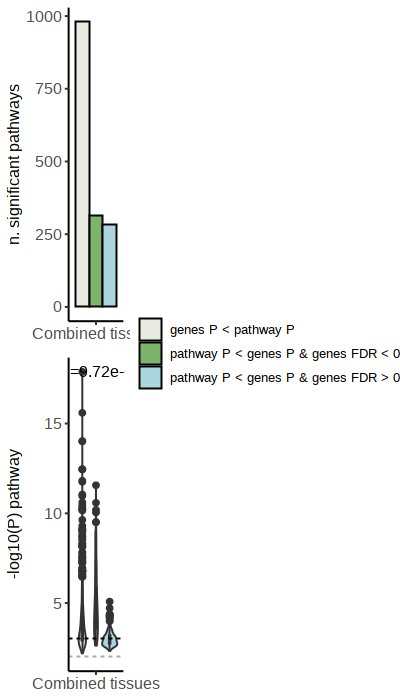

In [12]:
#######################################################################
### number of significant pathways that have better sign than genes ###
#######################################################################
# all tissues combined

options(repr.plot.width = 4, repr.plot.height = 7, repr.plot.res = 100)
pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
               fold = out_fold, pheno = pheno)

pl_npath$pl
table(pl_npath$df$class)
table(pl_npath$df$class)/nrow(pl_npath$df)
nrow(pl_npath$df)
a = pl_npath$df[order(pl_npath$df$log10p, decreasing = T),]
#a[a$class == 'pathway P < genes P\ngenes FDR < 0.05',][1:10,]
#a[a$class == 'pathway P < genes P\ngenes FDR > 0.05',][1:10,]
a[grepl('cell adhesion', a$path),]
a[grepl('cell migration', a$path),]

path_complete_ann <- path_complete
path_complete_ann$class_pathway <- NA
pl_npath$df$class <- as.character(pl_npath$df$class)
for(i in 1:nrow(path_complete_ann)){
  id <- pl_npath$df$path == path_complete_ann$path[i] & pl_npath$df$tissue == path_complete_ann$tissue[i] & pl_npath$df$type_path == path_complete_ann$type_path[i] 
  path_complete_ann$class_pathway[i] <- pl_npath$df$class[id]
}
# save
write.table(path_complete_ann, file = sprintf('%sPathScores_SCZ_annNewLoci_withReplicationCMC_annClass.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

                                       
                                        genes P < pathway P
  Brain_Caudate_basal_ganglia                            61
  Brain_Cerebellar_Hemisphere                            77
  Brain_Cerebellum                                      111
  Brain_Cortex                                           80
  Brain_Frontal_Cortex_BA9                              115
  Brain_Hippocampus                                      69
  Brain_Hypothalamus                                     65
  Brain_Nucleus_accumbens_basal_ganglia                  27
  Cells_EBV-transformed_lymphocytes                     156
  DLPC_CMC                                              219
                                       
                                        pathway P < genes P & genes FDR < 0.05
  Brain_Caudate_basal_ganglia                                               46
  Brain_Cerebellar_Hemisphere                                               40
  Brain_Cerebellum     

                                       
                                        genes P < pathway P
  Brain_Caudate_basal_ganglia                     0.4013158
  Brain_Cerebellar_Hemisphere                     0.4842767
  Brain_Cerebellum                                0.6065574
  Brain_Cortex                                    0.5405405
  Brain_Frontal_Cortex_BA9                        0.7232704
  Brain_Hippocampus                               0.6509434
  Brain_Hypothalamus                              0.6435644
  Brain_Nucleus_accumbens_basal_ganglia           0.5625000
  Cells_EBV-transformed_lymphocytes               0.7255814
  DLPC_CMC                                        0.7133550
                                       
                                        pathway P < genes P & genes FDR < 0.05
  Brain_Caudate_basal_ganglia                                        0.3026316
  Brain_Cerebellar_Hemisphere                                        0.2515723
  Brain_Cerebellum     

                                       
                                            FALSE      TRUE
  Brain_Caudate_basal_ganglia           0.5986842 0.4013158
  Brain_Cerebellar_Hemisphere           0.5157233 0.4842767
  Brain_Cerebellum                      0.3934426 0.6065574
  Brain_Cortex                          0.4594595 0.5405405
  Brain_Frontal_Cortex_BA9              0.2767296 0.7232704
  Brain_Hippocampus                     0.3490566 0.6509434
  Brain_Hypothalamus                    0.3564356 0.6435644
  Brain_Nucleus_accumbens_basal_ganglia 0.4375000 0.5625000
  Cells_EBV-transformed_lymphocytes     0.2744186 0.7255814
  DLPC_CMC                              0.2866450 0.7133550

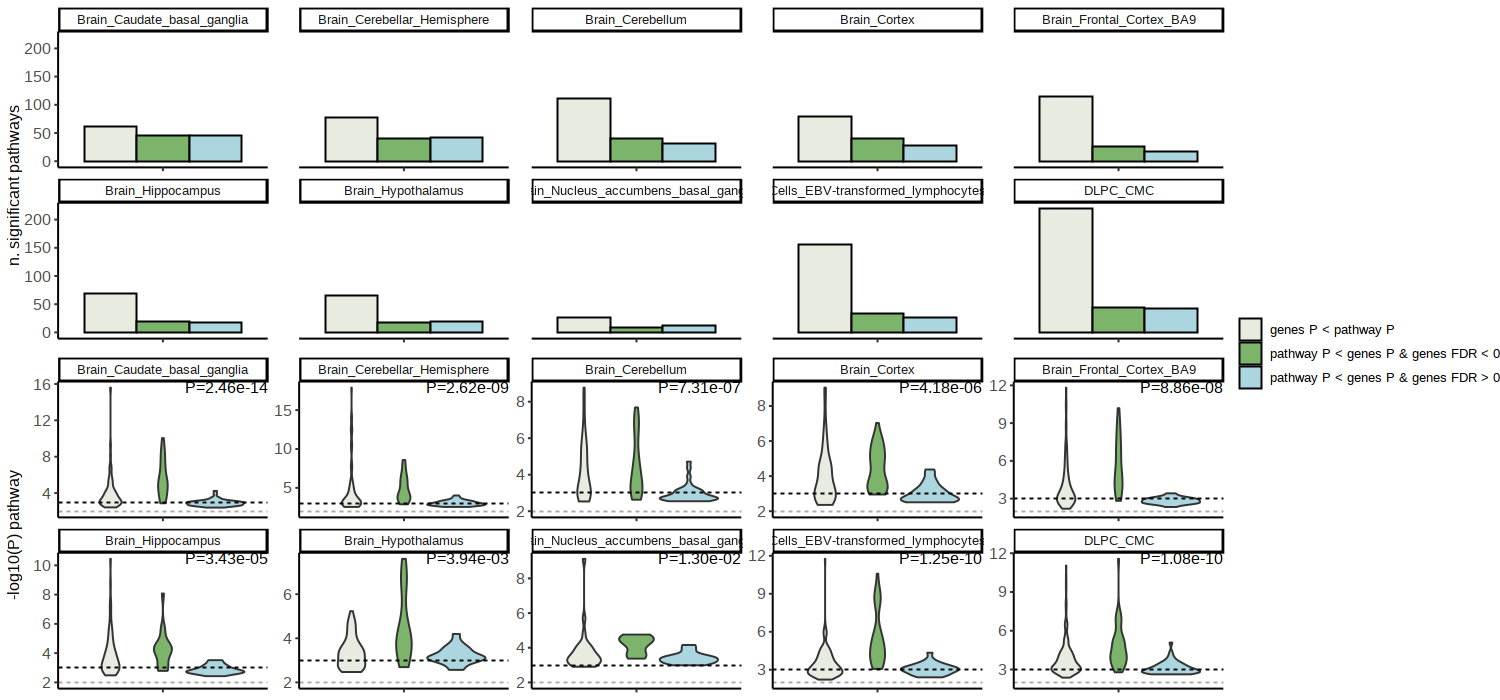

In [13]:
# tissue specific
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100)

pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
               fold = paste0(out_fold, '/tissueSpec_'), pheno = pheno, tissue_type = 'specific', width_pl = 10, height_pl = 7)

pl_npath$pl
# number/percentage of pathway class per tissue
table(pl_npath$df$tissue, pl_npath$df$class)
table(pl_npath$df$tissue, pl_npath$df$class)/rowSums(table(pl_npath$df$tissue, pl_npath$df$class))
table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P')/rowSums(table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P'))


png 
  2

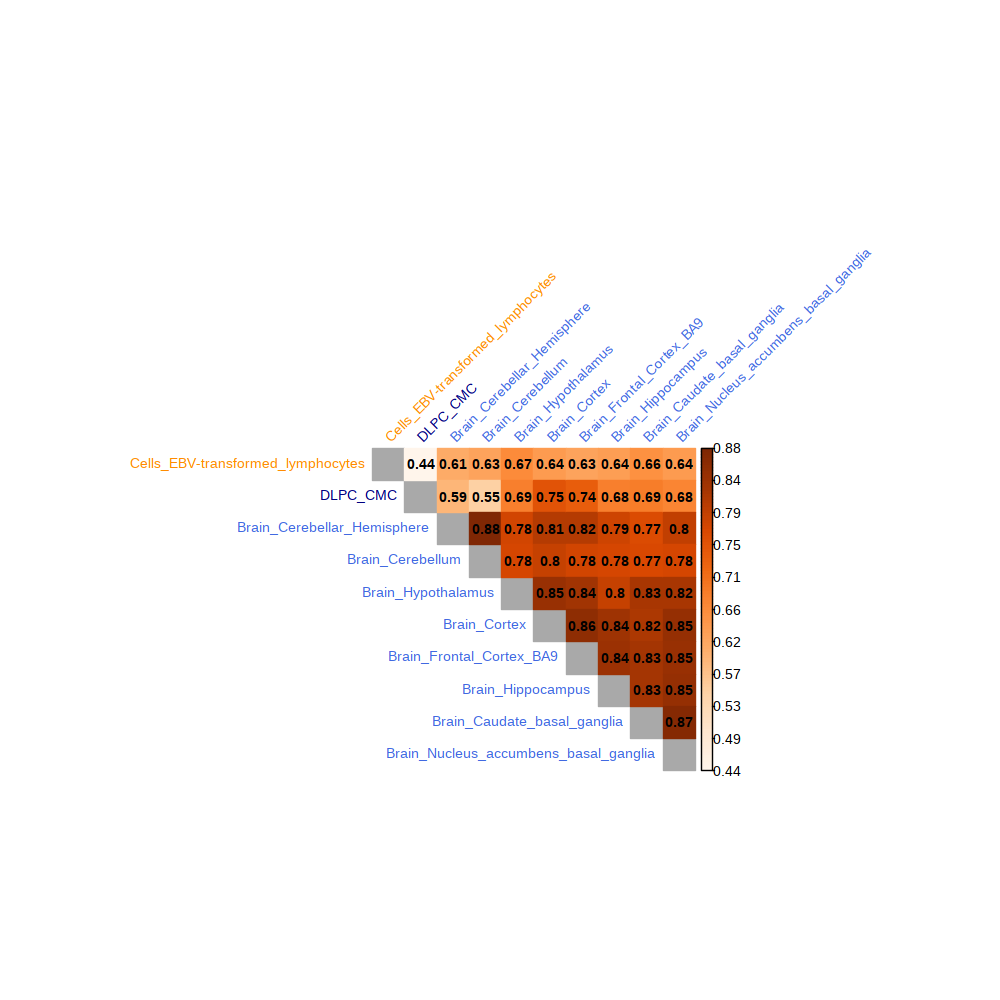

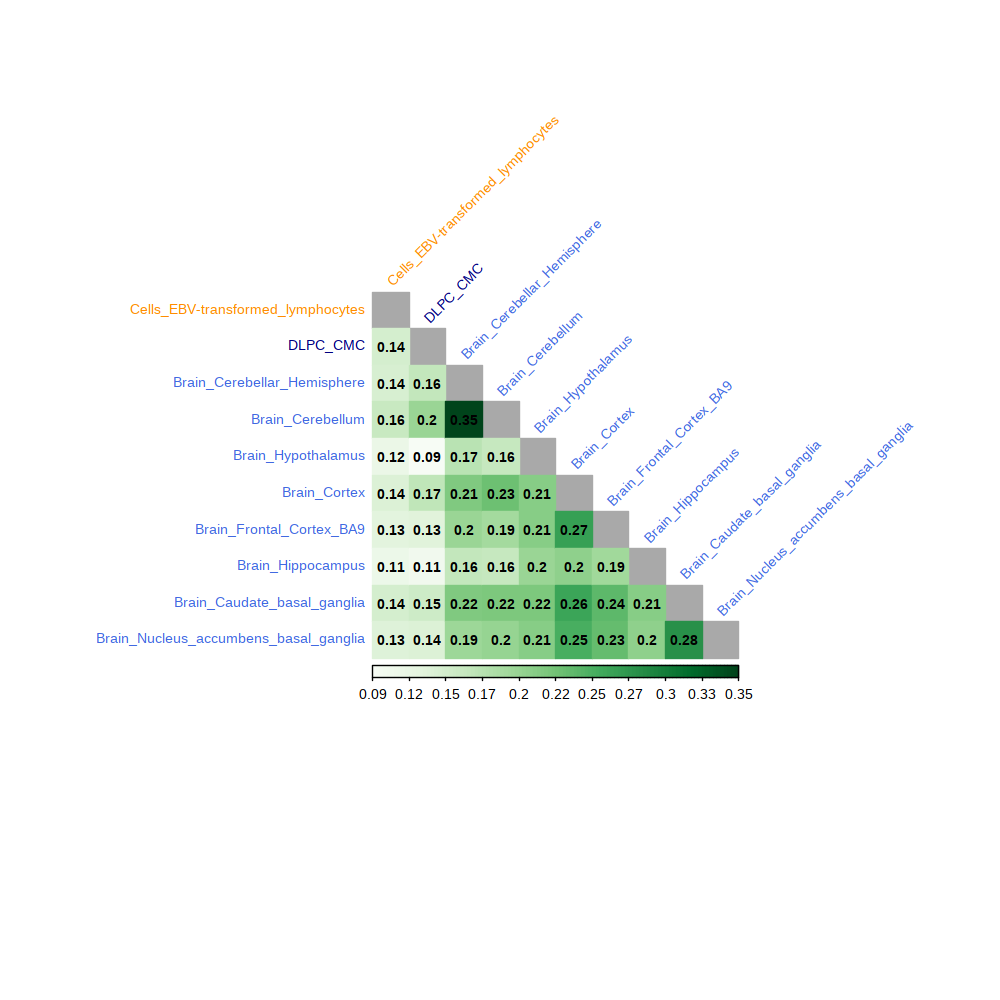

In [14]:
###########################################################
### spearman correlation and Jaccard index shared genes ###
###########################################################
# Fig 3 B
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

tscore_cor <- create_cor(tissues_name = tissues, res = tscore, id_z = 7)
# save
pl_corr(tscore_cor, type_mat = 'tscore', type_dat = type_dat, tissues_name = tissues, df_color = color_tissues, outFold = out_fold, width_pl = 10, height_pl = 7)

# print plots corr + perc
col_val <- colorRampPalette(brewer.pal(9, "Oranges"))
ord <- corrMatOrder(tscore_cor$cor, order = "hclust", hclust.method = "ward.D")
newcolours <- color_tissues$color[match(tissues, color_tissues$tissues)][ord]
diag(tscore_cor$cor) <- NA
corrplot(tscore_cor$cor, type = "upper", order = "hclust", hclust.method = "ward.D", 
        tl.col = newcolours, col = col_val(100), tl.cex = 0.8,
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", 
        na.label = "square", na.label.col = "darkgrey", is.corr = FALSE, 
        number.cex = 0.8)

diag(tscore_cor$perc) <- NA
col_val <- colorRampPalette(brewer.pal(9, "Greens"))(100)
corrplot(tscore_cor$perc[ord, ord], type = "lower", tl.col = newcolours, 
        col = col_val, method = "color", tl.srt = 45, tl.cex = 0.8,
        cl.align.text = "c", addCoef.col = "black", na.label = "square", 
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8)


[1] "tscore"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,26846,1274,12613,768


[1] "tscore not MHC"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,26292,979,12434,655


[1] "path-Reactome"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,7115,376,1485,255


[1] "path-GO"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,19457,1020,5258,692


[1] "path-Wiki Human"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,2594,174,445,125


[1] "path-CMC GeneSet"


,tissue,n_tot,n_sign,n_unique,n_unique_sign
,<fct>,<int>,<int>,<int>,<int>
11,All,271,8,271,8


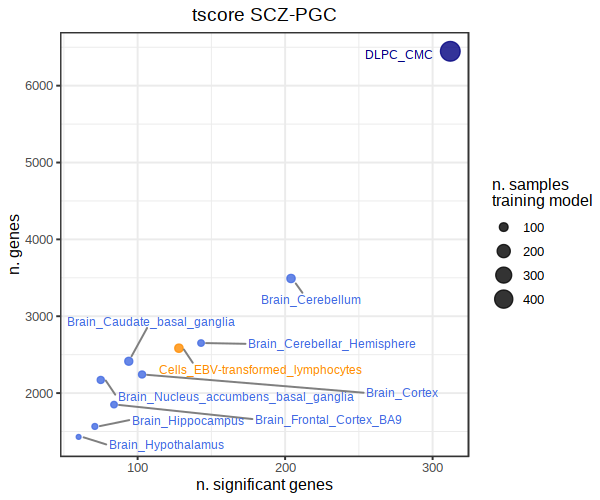

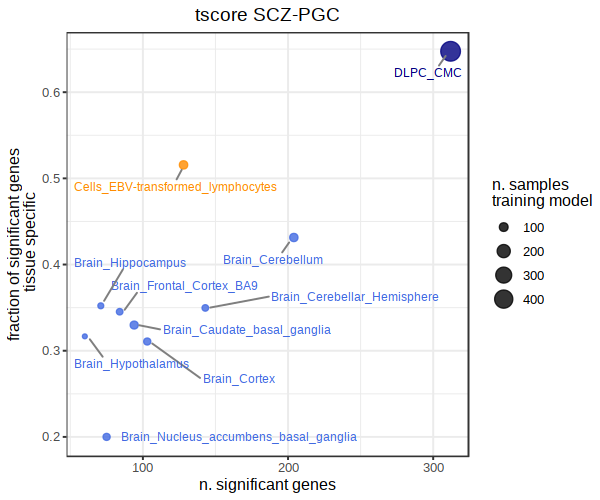

In [15]:
############################################################
### plot number of association per tissue vs specificity ###
############################################################
# Supplementary (to add)
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsign <- creat_dfnsign(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)
pathR_nsign <- creat_dfnsign(tissues_name = tissues, res = pathR, id_pval_corr = 15, 
                             pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 15)
pathGO_nsign <- creat_dfnsign(tissues_name = tissues, res = pathGO, id_pval_corr = 17, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 17)

pathwiki_nsign <- creat_dfnsign(tissues_name = tissues, res = pathWiki, id_pval_corr = 15, 
                                                  pval_FDR = pval_FDR, df_color = color_tissues,
                                id_pval_corr_tot = 15)
pathCMC_nsign <- creat_dfnsign(tissues_name = tissues, res = pathCMC, id_pval_corr = 15, 
                                                  pval_FDR = pval_FDR, df_color = color_tissues,
                                id_pval_corr_tot = 15)
tscore_red <- tscore
HLA_reg <- c(26000000, 34000000)
tscore_red <- tscore_red[!(tscore_red$chrom %in% 'chr6' & tscore_red$start_position <=HLA_reg[2] & tscore_red$start_position >= HLA_reg[1]) , ]
tscore_noMHC_nsign <- creat_dfnsign(tissues_name = tissues, res = tscore_red, id_pval_corr = 10, 
                                    pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)

print('tscore')
tscore_nsign$table[length(tissues)+1,]
print('tscore not MHC')
tscore_noMHC_nsign$table[length(tissues)+1,]
print('path-Reactome')
pathR_nsign$table[length(tissues)+1,]
print('path-GO')
pathGO_nsign$table[length(tissues)+1,]
print('path-Wiki Human')
pathwiki_nsign$table[length(tissues)+1,]
print('path-CMC GeneSet')
pathCMC_nsign$table[length(tissues)+1,]


# save
pl <- pl_number_function(df = tscore_nsign$plot, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl$ngen
pl$frac


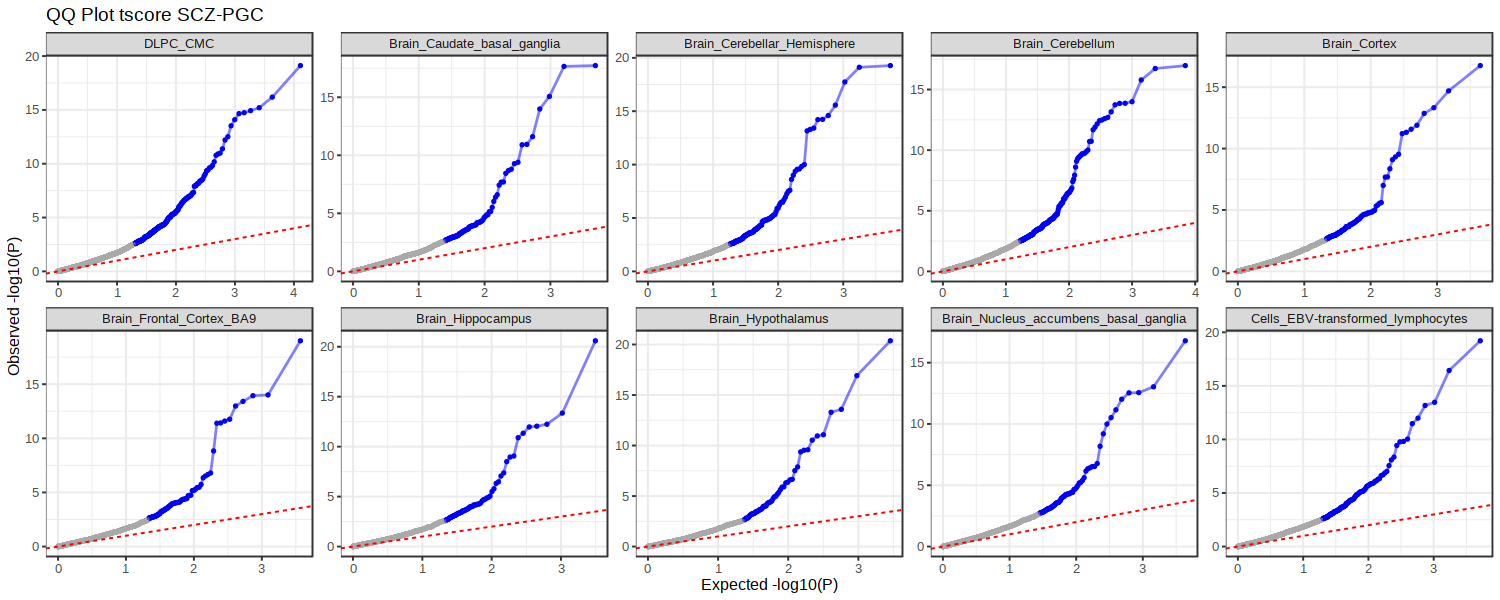

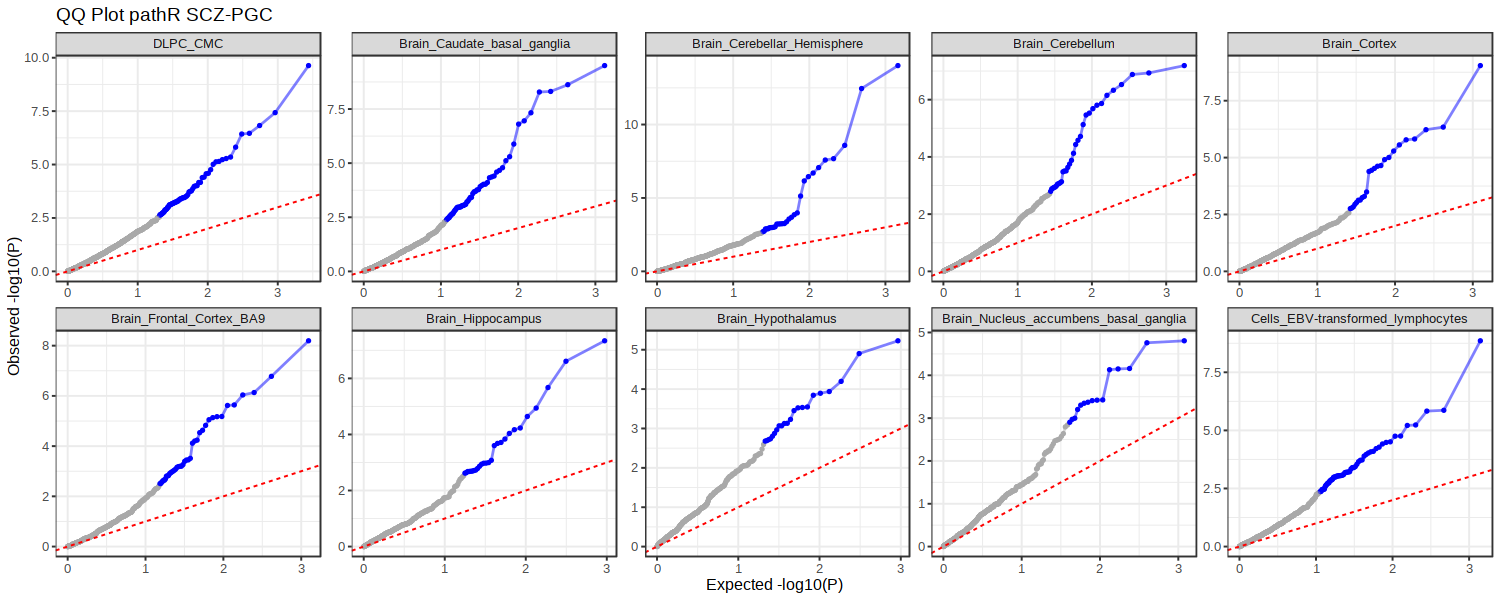

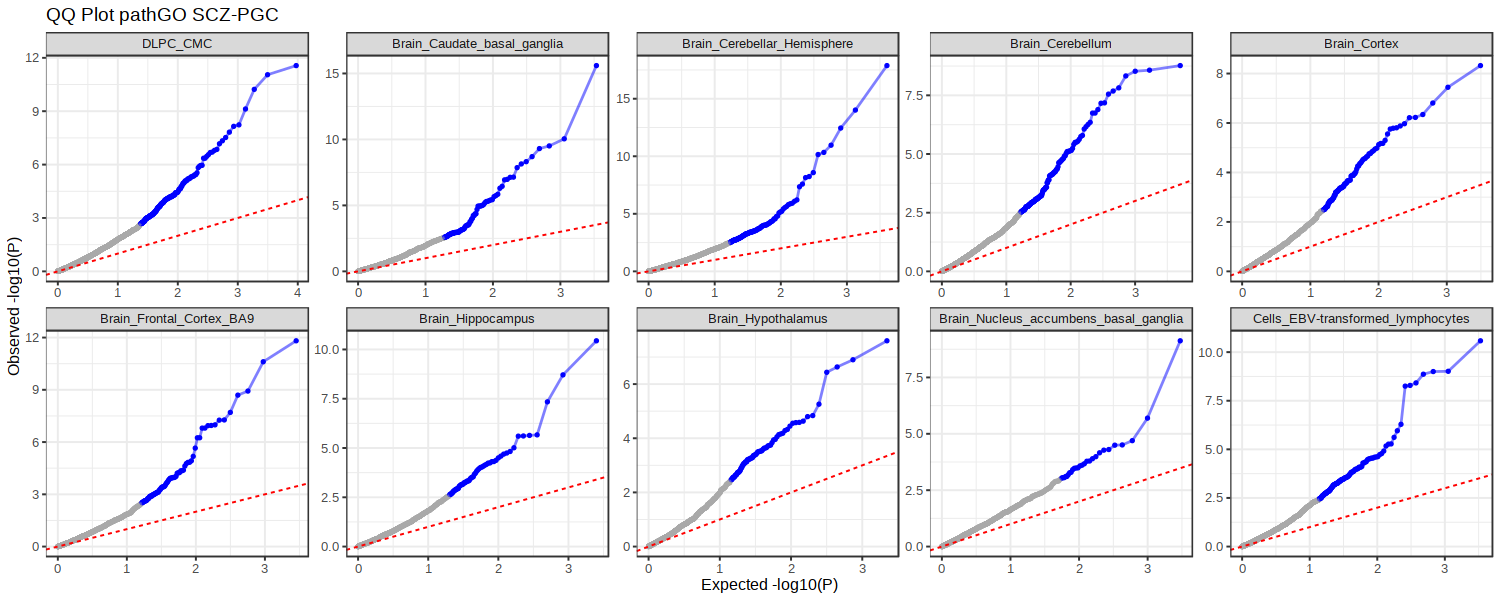

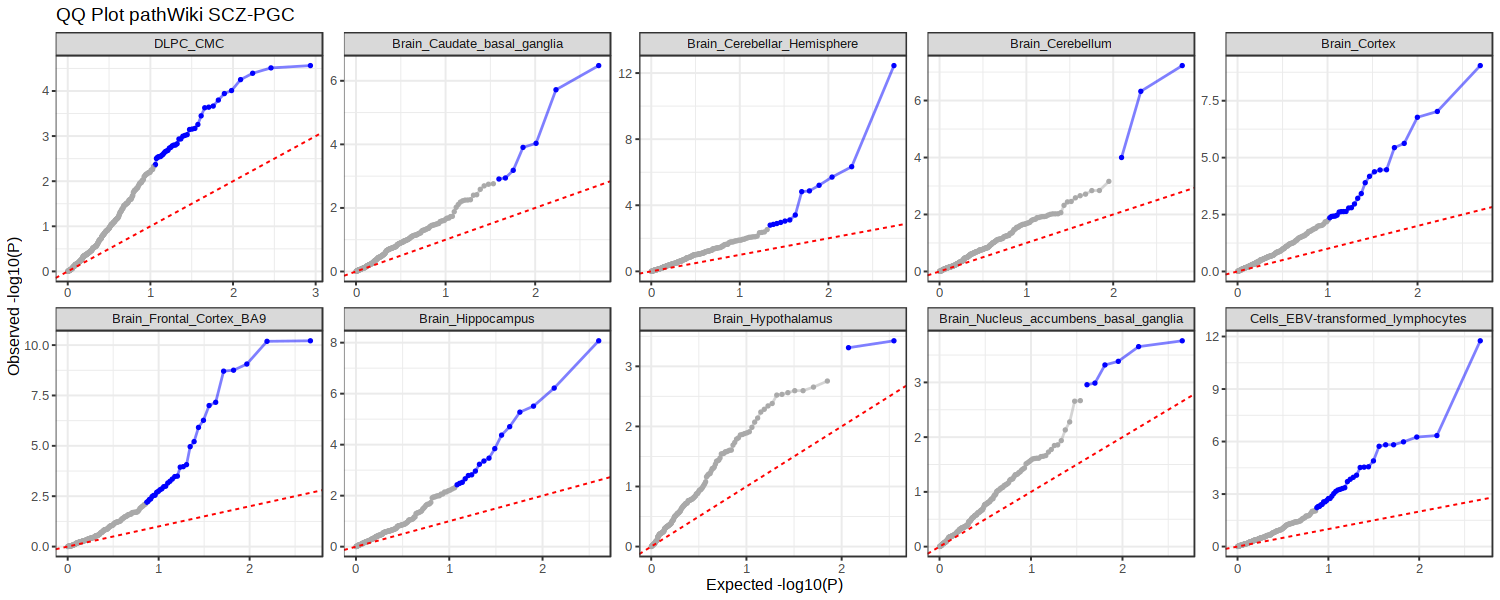

In [16]:
####################################
### plot qq-plot tissue specific ###
####################################
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 100)

# tscore
res <- qq_plot_tissues(data = tscore, color_tissues = color_tissues, id_pval = 8, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'tscore', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Reactome
res <- qq_plot_tissues(data = pathR, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathR', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path GO
res <- qq_plot_tissues(data = pathGO, color_tissues = color_tissues, id_pval = 15, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathGO', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Wiki
res <- qq_plot_tissues(data = pathWiki, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathWiki', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl



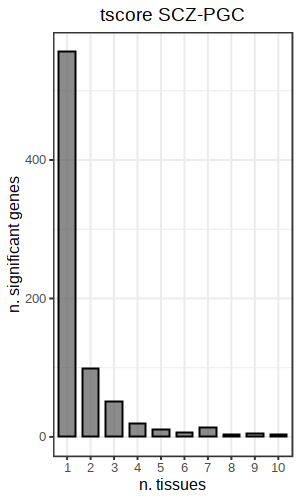

In [17]:
##################################################
### plot number of genes per number of tissues ###
##################################################
# Supplementary (to add)

options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 100)
tscore_nsgin_tissue <- creat_dfnsign_tissueSpec(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                                                pval_FDR = pval_FDR)
# save
pl <- pl_numberSpec_function(df = tscore_nsgin_tissue, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl

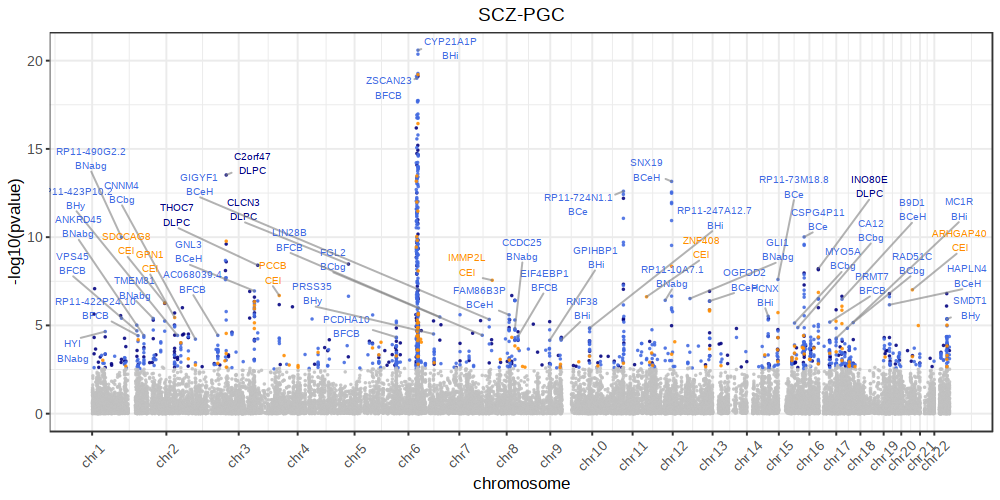

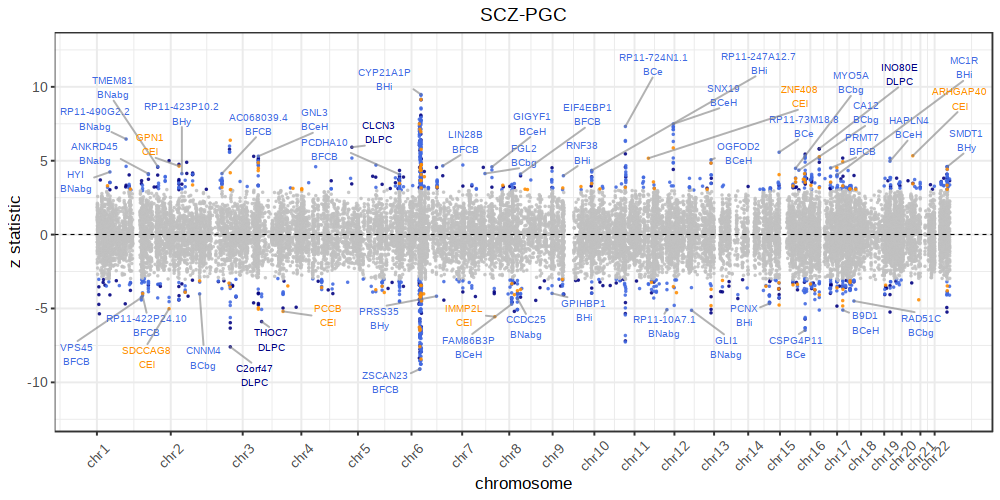

In [18]:
############################
### manhattan plot genes ###
############################
# Fig. 1A
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)

n_sign <- 30
convert_tissue_name <- function(vect_name){
  vect_name[vect_name %in% 'DLPC_CMC'] <- 'DLPC'
  vect_name[vect_name %in% 'Brain_Caudate_basal_ganglia'] <- 'BCbg'
  vect_name[vect_name %in% 'Brain_Cerebellar_Hemisphere'] <- 'BCeH'
  vect_name[vect_name %in% 'Brain_Cerebellum'] <- 'BCe'
  vect_name[vect_name %in% 'Brain_Cortex'] <- 'BC'
  vect_name[vect_name %in% 'Brain_Frontal_Cortex_BA9'] <- 'BFCB'
  vect_name[vect_name %in% 'Brain_Hippocampus'] <- 'BHi'
  vect_name[vect_name %in% 'Brain_Hypothalamus'] <- 'BHy'
  vect_name[vect_name %in% 'Brain_Nucleus_accumbens_basal_ganglia'] <- 'BNabg'
  vect_name[vect_name %in% 'Cells_EBV-transformed_lymphocytes'] <- 'CEl'  
  
  return(vect_name)
}
tissues_short <- convert_tissue_name(tissues)
tscore_short <- tscore 
tscore_short$tissue <- convert_tissue_name(tscore_short$tissue)
color_tissues_short <- color_tissues
color_tissues_short$tissues <- convert_tissue_name(color_tissues_short$tissues)

# for each tissue keep name of the 30 most significant genes
tscore_df <- create_df_manhattan_plot(tissues_name = tissues_short, res = tscore_short, id_pval = 8, 
                                      pval_FDR = pval_FDR, df_color = color_tissues_short, id_name = 2, 
                                      n_sign = n_sign, gene = T)
# include only 1 gene per locus
new_list <- tscore_df$df[tscore_df$df$sign_name == 'yes', ]
dist_mat <- as.matrix(dist(new_list$id_pos, method = 'manhattan'))
keep_t <- new_list$name
# recursevly until no intersection
tmp <- new_list
while(any(dist_mat[upper.tri(dist_mat)] < 3)){
  
  t_list <- apply(dist_mat, 1, function(x) x < 3)
  len_t <- c()
  keep_t <- c()
  for(j in 1:nrow(t_list)){
    tmp_sel <-  new_list[new_list$name %in% tmp$name[t_list[j,]],]
    tmp_sel <- tmp_sel[!tmp_sel$name %in% len_t, ]
    len_t <- unique(c(len_t, tmp_sel$name))
    keep_t <- unique(c(keep_t, tmp_sel$name[which.max(tmp_sel$pval_tr)]))
  }
  
  tmp <- tmp[tmp$name %in% keep_t, ]
  dist_mat <- as.matrix(dist(tmp$id_pos,method = 'manhattan'))
  
}
tscore_df$df$sign_name[tscore_df$df$sign_name == 'yes' & !tscore_df$df$name %in% tmp$name] <- 'no'
tscore_df$df$name[tscore_df$df$sign_name == 'no'] <- ''

# save
pl_tot <- pl_manhattan_function(data_input = tscore_df, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)
# plot
pl_tot$manhattan_pl
pl_tot$zstat_pl
                  
               

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


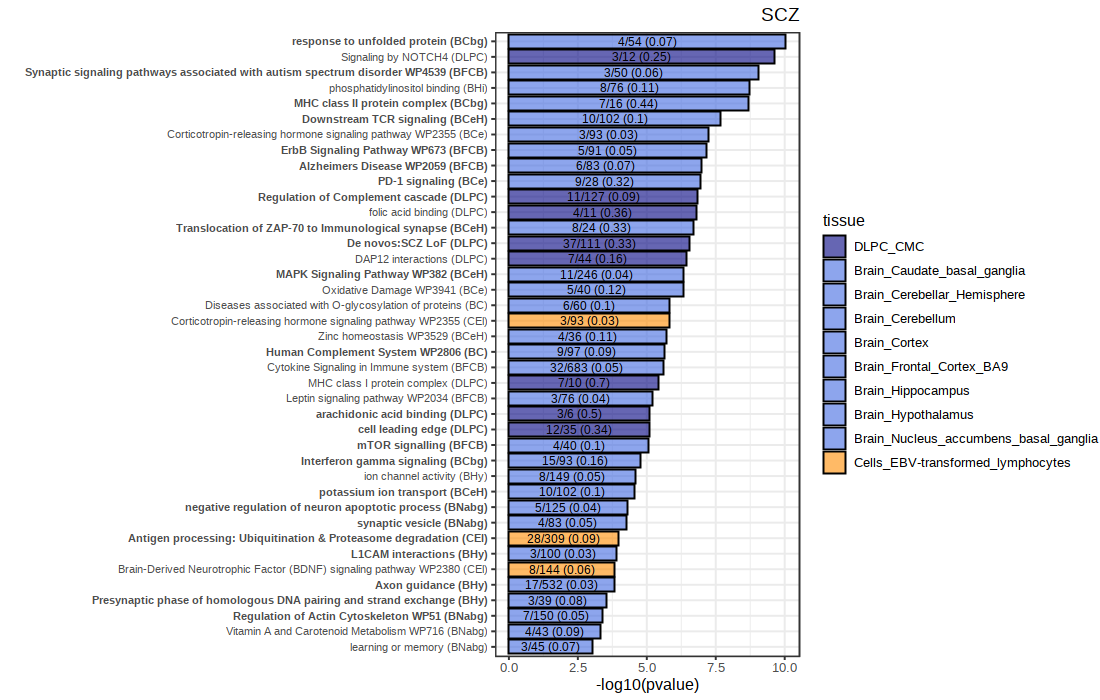

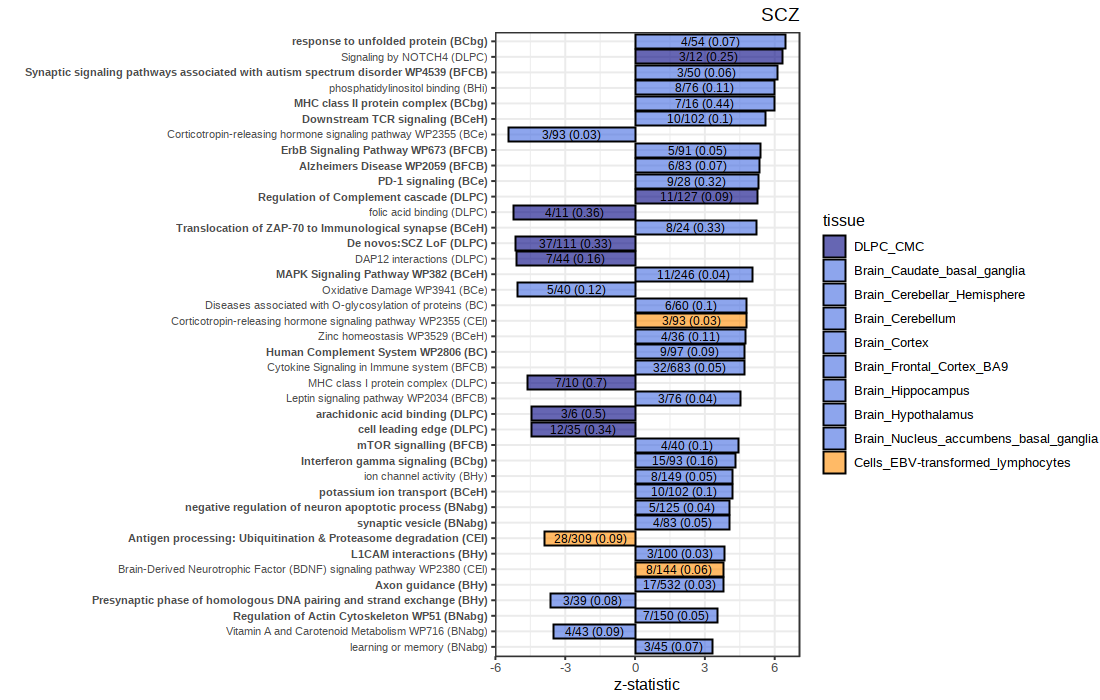

In [19]:
##############################################
### barplot selection significant pathways ###
##############################################
# Fig. 1C
options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 100)
keep_path_file <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/keep_path_SCZ_plot_v3.csv'

pathR$type <- 'Reactome'
pathGO$type <- 'GO'
pathCMC$type <- 'CMC'
pathWiki$type <- 'Wiki2019Human'
common_h <- intersect(colnames(pathCMC), intersect(colnames(pathWiki), intersect(colnames(pathR), colnames(pathGO))))
tot_path <- rbind(pathR[, match(common_h, colnames(pathR))], pathGO[, match(common_h, colnames(pathGO))], 
                  pathWiki[, match(common_h, colnames(pathWiki))], pathCMC[match(common_h, colnames(pathCMC))])

tmp_path <- read.csv(keep_path_file, h=T, stringsAsFactors = F)
tmp_path <- apply(tmp_path, 1, function(x) paste0(x, collapse = '_'))
tot_path_id <- apply(tot_path[, c('path', 'tissue', 'type')], 1, function(x) paste0(x, collapse = '_'))
best_path <- tot_path[match(tmp_path, tot_path_id), ]

best_path$logpval <-  -log10(best_path[, 13]) 
best_path$zstat <- best_path[, 12]
# save
pl <- plot_best_path(best_res = best_path, color_tissues = color_tissues, title_plot = pheno, type_mat = 'path', 
               outFold = out_fold, type_dat = type_dat, tissues = tissues, height_plot = 7, width_plot = 11, 
               id_pval = 13)
# plot
pl$pl_pval
pl$pl_zstat


[1] "cell leading edge"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr5"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr15"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "De novos:SCZ LoF"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr4"
[1] "chr6"
[1] "chr7"
[1] "chr8"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr12"
[1] "chr14"
[1] "chr16"
[1] "chr17"
[1] "chr18"
[1] "chr19"
[1] "chr20"
[1] "chr22"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "Regulation of Complement cascade"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr3"
[1] "chr6"
[1] "chr9"
[1] "chr11"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


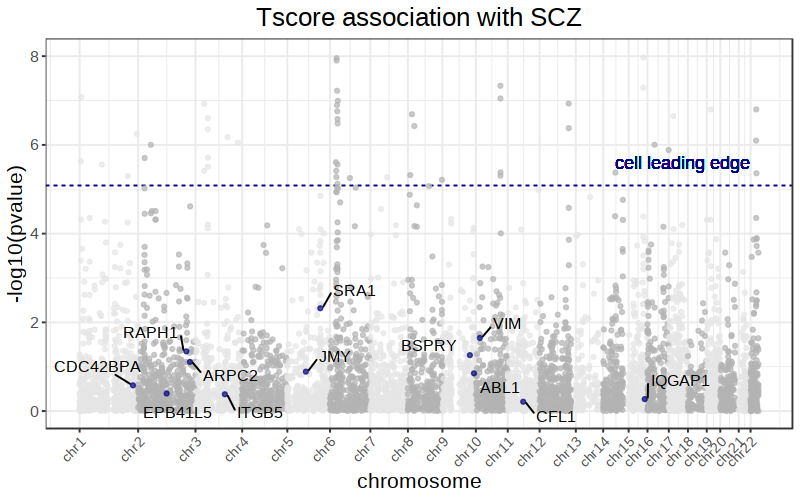

Warning message:
“Removed 29 rows containing missing values (geom_point).”


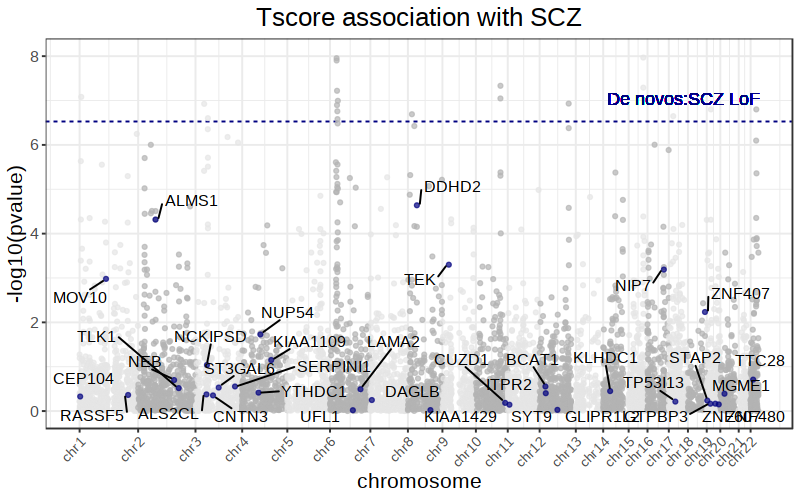

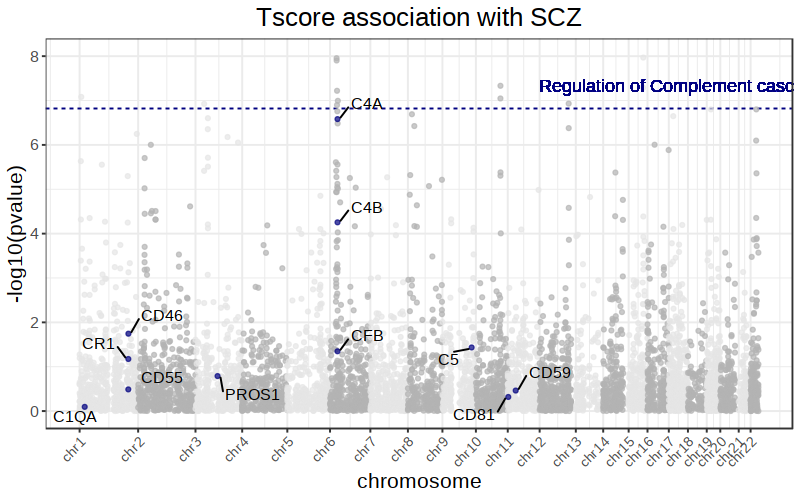

In [20]:
###################################
### showcase pathway enrichment ###
###################################
# Fig. 1D
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

id_pval <- 1
tissue <- 'DLPC_CMC'
pathways <- c('cell leading edge', 'De novos:SCZ LoF', 'Regulation of Complement cascade')

train_fold_original <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/'
fold_tissue <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/'
fold_geno_input <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/Genotype_VariantsInfo_maf001_info06_CMC-PGCgwas-SCZ-PGCall_'

for(pathway in pathways){
    
    print(pathway)
    color_tmp <- color_tissues$color[color_tissues$tissues == tissue]
    id_pval_path <-13
    if(pathway == 'De novos:SCZ LoF'){
         info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr_customPath_CMC_GeneSets.RData', fold_tissue[1])))
         id <- which(info_res$pathScore[[id_pval]]$path == pathway)
         genes_path <- info_res$info_pathScore[[id_pval]][[id]]  
    }else{
        info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr.RData', fold_tissue[1])))
        id1 <- which(info_res$pathScore_reactome[[id_pval]]$path == pathway)
        id2 <- which(info_res$pathScore_GO[[id_pval]]$path == pathway)
        id <- ifelse(length(id1) > 0, id1, id2)
        if(length(id1) > 0){
          genes_path <- info_res$info_pathScore_reactome[[id_pval]][[id]]  
        }else{
          genes_path <- info_res$info_pathScore_GO[[id_pval]][[id]]
          id_pval_path <- 15
        }
        
    }
    
    gene_res <- info_res$tscore[[id_pval]]
    gene_info <- fread(sprintf('%sresPrior_regEval_allchr.txt', train_fold[grepl(tissue, train_fold)]), h=T,stringsAsFactors = F, data.table = F)
    resBeta <- get(load(sprintf('%sresPrior_regCoeffSnps_allchr.RData',  train_fold[grepl(tissue, train_fold)])))
    train_fold_tissue <- train_fold[grepl(tissue, train_fold)]
    
    # save
    pl <- plot_showcase(gene_res = gene_res, gene_info = gene_info, genes_path = genes_path, 
                  tissue = tissue, pathway = pathway, color_tmp = color_tmp, id_pval_path = id_pval_path, 
                  pheno = pheno, fold = out_fold, resBeta = resBeta, train_fold_tissue = train_fold_tissue, 
                  fold_geno_input_tmp = fold_geno_input, 
                  train_fold_original_tmp = train_fold_original, name_gwas_pval = 'PVAL')
    # warnings refer to most significant associations (in general) that are removed if not used in the pathway for display reasons
    # plot
    print(pl$pl_manh)    
}

  

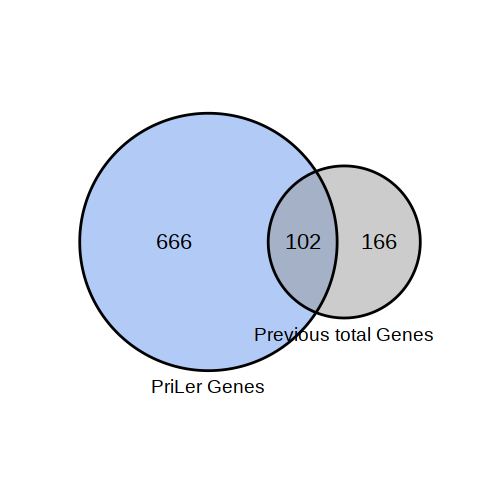

In [21]:
#################################################
### intersect with prediXcan and TWAS results ###
#################################################
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
previous_genes_file <- 'SCZ_PGC/eQTL_PROJECT/previousGenes_TWAS_prediXcan.RData'
venn_pl <- venn_plot_genes(genes_known_file = previous_genes_file, tscore = tscore, pval_FDR = pval_FDR, 
                type_mat = 'path', fold = out_fold, type_dat = type_dat)

grid.draw(venn_pl[[length(venn_pl)]])


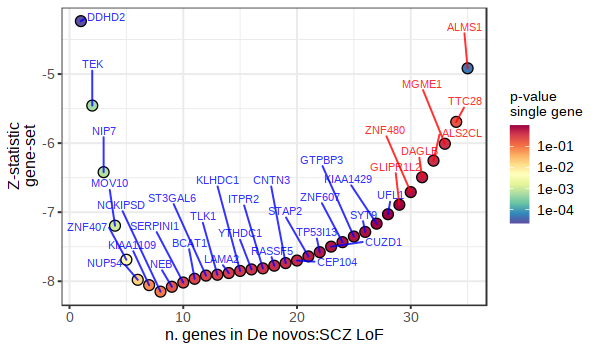

In [22]:
################################################
### incremental significance SCZ loF example ###
################################################
options(repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 100)
source(functR)
pval_incr <- get(load('SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/pval_Dx_pheno_covCorr_customPath_SCZ_LoF_signed_GeneSets.RData'))
path_info <- get(load('priler_project/refData/SCZ_LoF_signed_GeneSets_ordered.RData'))

# top to bottom
n_genes <- max(pval_incr$pathScore[[1]]$ngenes_tscore)
id <- which(sapply(path_info, function(x) x$name == sprintf('De novos:SCZ LoF most sign. n %i', n_genes)))
gene_order <- path_info[[35]]$geneIds

pl_incr <- plot_increment(gene_order = gene_order, path_res = pval_incr$pathScore[[1]][grepl('most', pval_incr$pathScore[[1]]$path), ], 
               gene_res = pval_incr$tscore[[1]], title_plot = 'SCZ_LoF_signed_GeneSets_decreasedOrder', fold = out_fold)

pl_incr


png 
  2

png 
  2

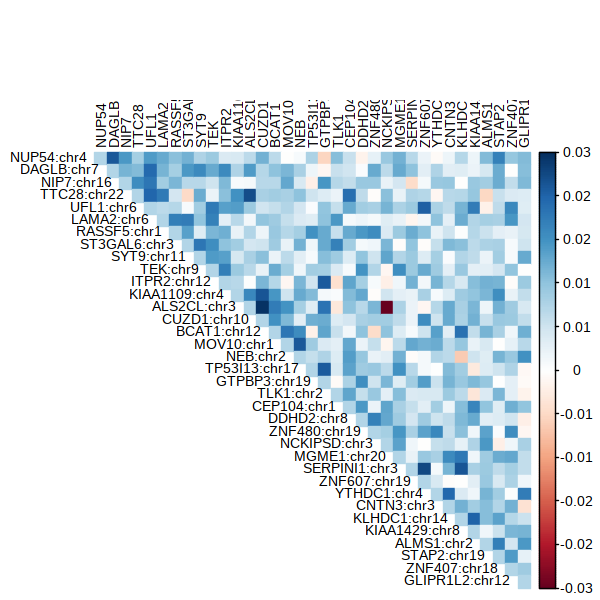

In [23]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)

cor_res <- get(load('SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/cor_custom_geneList_SCZ_LoF_GeneSets_combined.RData'))
cor_mat <- cor_res$cor
diag(cor_mat) <- 0
new_name <- paste0(colnames(cor_mat), ':', cor_res$geneAnn$chrom)
rownames(cor_mat) <- new_name

# col <- colorRampPalette(brewer.pal(9, 'Oranges'))(100)
val <- round(max(abs(cor_mat), na.rm = T), digits = 2)

ord <- corrMatOrder(cor_mat, order="hclust", hclust.method = 'ward.D')

pdf(file = sprintf('%scorr_genes_SCZ_LoF.pdf', out_fold), width = 6, height = 6, compress = F)
corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c',tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))
dev.off()

png(file = sprintf('%scorr_genes_SCZ_LoF.png', out_fold), units = 'in', width = 6, height = 6, res = 300)
corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c', tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))
dev.off()

corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c', tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))


[1] 75

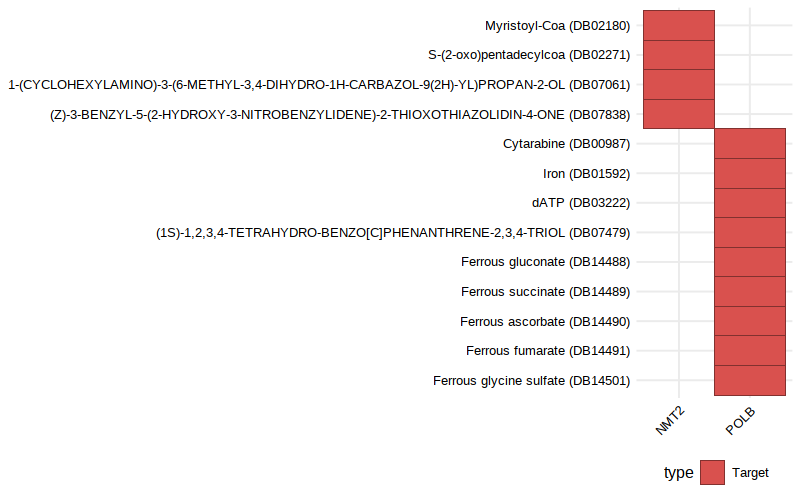

In [61]:
######################################
### annotate genes by drug targets ###
######################################

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)
library(drugbankR)
drugbank_genes <- 'refData/drugBank/All_geneTargets_enzymes.txt'
df <- queryDB(type = "getAll", db_path=sprintf("%sdrugbank_5.1.7.db", 'refData/drugBank/'))
id_SCZ = unique(c(grep("schizophrenia", df$`mechanism-of-action`), grep("schizophrenia", df$indication)))
name_SCZ <- unique(df[id_SCZ, "drugbank-id"])

genes_sign <- unique(tscore_complete$external_gene_name)
genes_new <- unique(tscore_complete$external_gene_name[!tscore_complete$best_GWAS_signBH])
db_genes <- fread(drugbank_genes, h=T, stringsAsFactors = F, data.table = F)

db_genes_sign <- db_genes[db_genes$gene %in% genes_new,]
db_genes_sign <- db_genes_sign[order(db_genes_sign$gene), ]

# create 0-1 matrix drugs x targets
db_drug_name <- db_genes_sign[!duplicated(db_genes_sign$id), 1:2]
drug_gene_mat <- matrix(0,nrow = nrow(db_drug_name), ncol = length(unique(db_genes_sign$gene)))
rownames(drug_gene_mat) <- paste0(db_drug_name$drug, ' (', db_drug_name$id, ')')
colnames(drug_gene_mat) <- unique(db_genes_sign$gene)
for(i in 1:nrow(db_drug_name)){
    id <- colnames(drug_gene_mat) %in% db_genes_sign$gene[db_genes_sign$id == db_drug_name$id[i]]
    gene_type <- sapply(which(id), function(x) db_genes_sign$class[db_genes_sign$id == db_drug_name$id[i] & db_genes_sign$gene == colnames(drug_gene_mat)[x]])
    drug_gene_mat[i, id] <- gene_type
}
#drug_gene_mat
                        
# plot 
db_genes_sign$new_name <- paste0(db_genes_sign$drug, ' (', db_genes_sign$id, ')') 
db_genes_sign$new_name <- factor(db_genes_sign$new_name, levels = rev(unique(db_genes_sign$new_name)))
db_genes_sign$type <- NA
db_genes_sign$type[db_genes_sign$class == 'E'] <- 'Enzyme'
db_genes_sign$type[db_genes_sign$class == 'TR'] <- 'Transporters'           
db_genes_sign$type[db_genes_sign$class == 'T'] <- 'Target'
db_genes_sign$type <- factor(db_genes_sign$type, levels = c('Target', 'Transporters', 'Enzyme'))

pl <- ggplot(db_genes_sign, aes(gene, new_name)) + 
            geom_tile(aes(fill = type), colour = "black") + 
            theme_minimal()+
            theme(axis.title = element_blank(), axis.text = element_text(color = 'black'), 
                 axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'bottom')+
            scale_fill_manual(values=c("#D9514EFF", "#2A2B2DFF", "#2DA8D8FF"))
pl
# save
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.png', out_fold, pheno), plot = pl, width = 8, height = 5, dpi = 500)
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.pdf', out_fold, pheno), plot = pl, width = 8, height = 5, compress = F)
  

In [62]:
#########################################
### annotate pathways by drug targets ###
#########################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
path_ann_drug <- path_complete_ann
#path_ann_drug <- path_complete_ann[path_complete_ann$type_path %in% c('Reactome', 'GO') & path_complete_ann$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
#path_ann_drug <- path_ann_drug[(path_ann_drug$path %in% pathGO$path[pathGO$path_ont %in% c('BP' & 'MF')] & path_ann_drug$type_path %in% 'GO') | path_ann_drug$type_path %in% 'Reactome',]
path_ann_drug <- path_ann_drug[, c('path', 'ngenes_tscore', 'Dx_z', 'Dx_pval', 'Dx_pval_BHcorr', 'genes_path', 'tissue', 'class_pathway', 'type_path')]

path_ann_drug$drugBank_ann <- NA
path_ann_drug$drugBank_n <- NA
path_ann_drug$drugBank_id <- NA
path_ann_drug$drugBank_gene <- NA
path_ann_drug$drugBank_usedForSCZ <- NA

for(i in 1:nrow(path_ann_drug)){
    path_name = path_ann_drug$path[i]
    genes_path <- strsplit(path_ann_drug$genes_path[path_ann_drug$path == path_name], split = ',')[[1]]
    drug_ann <- db_genes[db_genes$gene %in% genes_path,,drop = F]
    path_ann_drug$drugBank_ann[i] <- paste0(unique(drug_ann$drug), collapse = '-and-')
    path_ann_drug$drugBank_id[i] <- paste0(unique(drug_ann$id), collapse = '-and-')
    path_ann_drug$drugBank_n[i] <- nrow(drug_ann)
    path_ann_drug$drugBank_gene[i] <- paste0(unique(drug_ann$gene), collapse = '-and-')
    path_ann_drug$drugBank_usedForSCZ[i] <- paste0(unique(drug_ann$drug[drug_ann$id %in% name_SCZ]), collapse = '-and-')
}

# save table
write.table(path_ann_drug, file = sprintf('%sPathScore_SCZ_annotated_drugBank.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

# reduce category
path_ann_drug_red <- path_ann_drug[path_ann_drug$type_path %in% c('Reactome', 'GO') & path_ann_drug$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
path_ann_drug_red <- path_ann_drug_red[(path_ann_drug_red$path %in% pathGO$path[pathGO$path_ont %in% c('BP', 'MF')] & path_ann_drug_red$type_path %in% 'GO') | path_ann_drug_red$type_path %in% 'Reactome',]
# save table
write.table(path_ann_drug_red, file = sprintf('%sPathScore_SCZ_annotated_drugBank_notSignGenes_GOandReactome.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)